In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image


In [2]:
class Network:
    def __init__(self, eta, layers, max_i=10000, max_error=0.01):
        self._eta = eta
        self._layers = layers
        self._w = []
        self._y = []
        self._delta = []
        self.max_i = max_i
        self.max_error = max_error

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def _create_weights(self, x_num):
        for i, layer_i in enumerate(self._layers):
            if i == 0:
                self._w.append(
                    np.random.uniform(-1, 1, size=(layer_i, x_num + 1)))
            else:
                self._w.append(
                    np.random.uniform(
                        -1, 1, size=(layer_i, self._w[i - 1].shape[0] + 1)
                    )
                )
            self._y.append(np.zeros(layer_i))
            self._delta.append(np.zeros(layer_i))

    def _forward_progation(self, x):
        for i in range(len(self._layers)):
            if i == 0:
                self._y[i] = np.dot(self._w[i], np.append(np.array(1), x))
            else:
                self._y[i] = np.dot(self._w[i], np.append(
                    np.array(1), self._y[i - 1]))
            self._y[i] = self.sigmoid(self._y[i])

    def _backward_propagation(self, expected_output):
        for i in range(len(self._y) - 1, -1, -1):
            if i == len(self._y) - 1:
                error = expected_output - self._y[i]
                self._delta[i] = error * self.sigmoid(self._y[i], True)
            else:
                self._delta[i] = np.dot(
                    self._w[i+1][:, 1:].T, self._delta[i+1]) * self.sigmoid(self._y[i], True)
        return error

    def _update(self, x):
        for i in range(len(self._layers)):
            for j in range(len(self._delta[i])):
                if i == 0:
                    self._w[i][j] += np.append([1], x) * \
                        self._delta[i][j] * self._eta
                else:
                    self._w[i][j] += (
                        np.append([1], self._y[i - 1]) *
                        self._delta[i][j] * self._eta
                    )

    def fit(self, x, y, verbose=False):
        self._create_weights(np.shape(x)[1])
        data = list(zip(x, y))
        for epoch in range(self.max_i):
            np.random.shuffle(data)
            E = 0
            for x_i, y_i in data:
                self._forward_progation(x_i)
                b = self._backward_propagation(y_i)
                b = b**2
                E += 0.5 * b.sum()
                self._update(x_i)
            if E < self.max_error:
                break
            if verbose:
                print(f"Epoka: {epoch+1} z {self.max_i}, blad: {E}")
        return E

    def predict(self, x):
        self._forward_progation(x)
        return self._y[-1]


In [3]:
def prepare_data(directory):
    data = []
    for file in os.listdir(directory):
        img = Image.open(os.path.join(directory, file))
        img = img.convert('RGB')
        img_box = np.array(img).reshape(3072, 64)
        data.append(img_box)
    return data


In [4]:
data = prepare_data('data/images')


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = scaler.fit_transform(np.concatenate(data))


In [6]:
network = Network(0.05, (32, 64), 100)
network.fit(x, x, True)


Epoka: 1 z 100, blad: 4758.0080004848005
Epoka: 2 z 100, blad: 1824.4012235224434
Epoka: 3 z 100, blad: 1386.8093888245648
Epoka: 4 z 100, blad: 1183.5739153789475
Epoka: 5 z 100, blad: 1057.720809263857
Epoka: 6 z 100, blad: 967.4180008395891
Epoka: 7 z 100, blad: 899.0498823348355
Epoka: 8 z 100, blad: 844.2139283859889
Epoka: 9 z 100, blad: 800.100131889365
Epoka: 10 z 100, blad: 763.3994996456662
Epoka: 11 z 100, blad: 732.5372832985512
Epoka: 12 z 100, blad: 706.8572177684689
Epoka: 13 z 100, blad: 683.3838139900822
Epoka: 14 z 100, blad: 663.7502362366869
Epoka: 15 z 100, blad: 646.4561909389208
Epoka: 16 z 100, blad: 630.1817057132907
Epoka: 17 z 100, blad: 615.9378160847066
Epoka: 18 z 100, blad: 602.5844929983379
Epoka: 19 z 100, blad: 590.9688029870159
Epoka: 20 z 100, blad: 579.9534475466886
Epoka: 21 z 100, blad: 569.0265947298217
Epoka: 22 z 100, blad: 560.2972749934414
Epoka: 23 z 100, blad: 551.5071205928107
Epoka: 24 z 100, blad: 543.27916450861
Epoka: 25 z 100, blad: 5

388.1464506985042

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
test = scaler.fit_transform(data[0])


In [8]:
result = []
for row in test:
    result.append(network.predict(row))


In [9]:
result = scaler.inverse_transform(result)


In [10]:
zdj = np.concatenate(result).reshape(256, 256, 3)
zdj = zdj.astype('uint8')


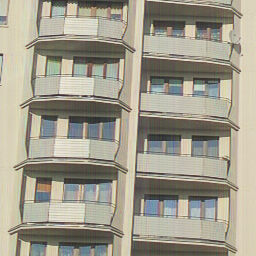

In [11]:
img2 = Image.fromarray(zdj, 'RGB')
img2.show()


In [79]:
img2.save('test.png')
